In [37]:
import keras
import sqlite3
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import data as tf_data
from sklearn.preprocessing import StandardScaler

In [38]:
CLASS_MAP = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

def parse_dataset():
    connection = sqlite3.connect("../backend/database.sqlite")

    train_class = []
    train_lat = []
    train_long = []
    train_day = []

    test_class = []
    test_lat = []
    test_long = []
    test_day = []

    cursor = connection.cursor()
    query_template = """
    SELECT FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, DISCOVERY_DOY
    FROM Fires
    WHERE FIRE_SIZE_CLASS = ?
    ORDER BY RANDOM()
    LIMIT ?
    """

    fires = []
    fire_classes = ["A", "B", "C", "D", "E", "F", "G"]

    for fire_class in fire_classes:
        cursor.execute(query_template, (fire_class, 3000))
        class_data = cursor.fetchall()
        fires.extend(class_data)

    print(f"Total number of fires: {len(fires)}")
    print(f"Number of classes: {len(fire_classes)}")
    print(f"Number of fires per class: {len(fires) / len(fire_classes)}")
    for fire_class in fire_classes:
        print(f"Number of {fire_class} fires: {len([fire for fire in fires if fire[0] == fire_class])}")


    i = 0
    train_cutoff = round(len(fires) * 0.8)
    for fire in tqdm(fires):
        i+= 1
        label, lat, long, day = fire
        label = CLASS_MAP[label]
        day = day / 366
        if i < train_cutoff:
            train_class.append(label)
            train_lat.append(lat)
            train_long.append(long)
            train_day.append(day)
        else:
            test_class.append(label)
            test_lat.append(lat)
            test_long.append(long)
            test_day.append(day)

    return (
        (np.array(train_lat), np.array(train_long), np.array(train_day)),
        (np.array(test_lat), np.array(test_long), np.array(test_day)),
        np.array(train_class),
        np.array(test_class),
    )

In [39]:
NUM_CLASSES=7
BATCH_SIZE=32

(train_inputs, test_inputs, train_labels, test_labels) = parse_dataset()
train_lat, train_long, train_day = train_inputs
test_lat, test_long, test_day = test_inputs

Total number of fires: 21000
Number of classes: 7
Number of fires per class: 3000.0
Number of A fires: 3000
Number of B fires: 3000
Number of C fires: 3000
Number of D fires: 3000
Number of E fires: 3000
Number of F fires: 3000
Number of G fires: 3000


100%|██████████| 21000/21000 [00:00<00:00, 2085828.93it/s]


In [40]:
dataset = tf_data.Dataset.from_tensor_slices(
    ((train_lat, train_long, train_day), train_labels)
)
dataset = dataset.shuffle(buffer_size=1024)
train_size = int(len(dataset) * 0.8)
validation_size = int(len(dataset) * 0.2)
train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_size).take(validation_size).batch(BATCH_SIZE)

test_dataset = tf_data.Dataset.from_tensor_slices(
    ((test_lat, test_long, test_day), test_labels)
)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [41]:
input_latitude = keras.Input(shape=(1,), name='latitude')
input_longitude = keras.Input(shape=(1,), name='longitude')
input_day = keras.Input(shape=(1,), name='day_of_year')


concatenated_inputs = keras.layers.Concatenate()(
    [input_latitude, input_longitude, input_day]
)

x = keras.layers.Dense(128, activation='relu')(concatenated_inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

output = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

# Build and compile model
model = keras.Model(inputs=[input_latitude, input_longitude, input_day], outputs=output)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ day_of_year         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3)         │          0 │ latitude[0][0],   │
│ (Concatenate)       │                   │            │ longitude[0][0],  │
│                     │                   │            │ day_of_year[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │        512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 7)         │        231 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,975 (46.78 KB)

 Trainable params: 11,527 (45.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4651 - sparse_categorical_accuracy: 0.1596 - val_loss: 2.0232 - val_sparse_categorical_accuracy: 0.2245
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.1758 - sparse_categorical_accuracy: 0.1876 - val_loss: 2.0395 - val_sparse_categorical_accuracy: 0.1119
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0571 - sparse_categorical_accuracy: 0.2120 - val_loss: 2.1064 - val_sparse_categorical_accuracy: 0.0247
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9758 - sparse_categorical_accuracy: 0.2210 - val_loss: 2.1419 - val_sparse_categorical_accuracy: 0.0146
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8974 - sparse_categorical_accuracy: 0.2466 - val_loss: 2.1803 - val_sparse_categorical_accuracy: 0.0104
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8514 - sparse_categorical_accuracy: 0.2499 - val_loss: 2.2322 - val_sparse_categorical_accuracy: 0.0065
Epoc

In [43]:
model.save("model.keras")

/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_78862/1937279587.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_78862/1937279587.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_78862/1937279587.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(
/var/folders/rw/b9js29716tj3qb0gm18586k00000gn/T/ipykernel_78862/1937279587.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1

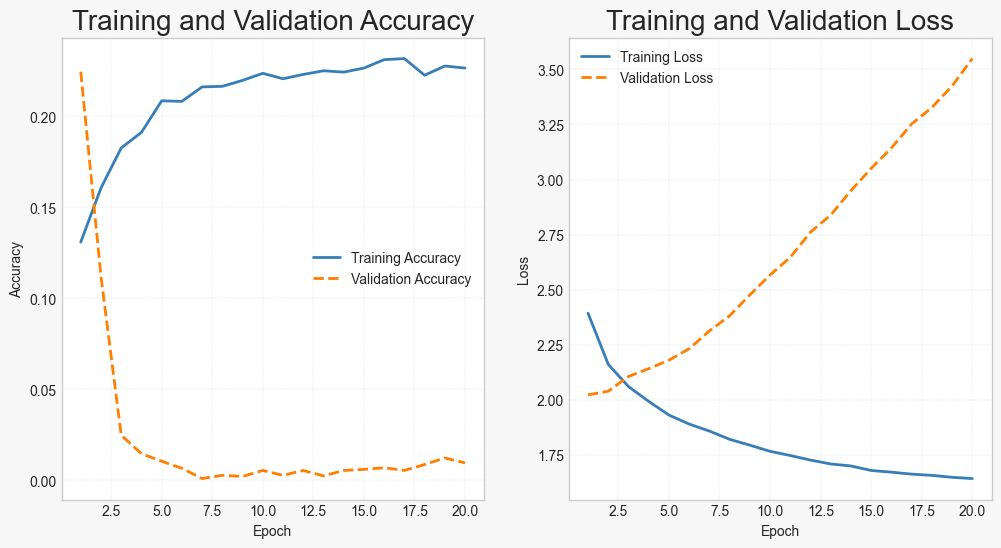

In [44]:
acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#377eb8", "#ff7f00"]
linestyles = ["-", "--"]

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor("#f7f7f7")

plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy", fontsize=20)
plt.plot(
    epochs,
    acc,
    "r",
    label="Training Accuracy",
    linestyle=linestyles[0],
    color=colors[0],
    linewidth=2,
)
plt.plot(
    epochs,
    val_acc,
    "b",
    label="Validation Accuracy",
    linestyle=linestyles[1],
    color=colors[1],
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True, linestyle="--", linewidth=0.2)

plt.subplot(1, 2, 2)
plt.title("Training and Validation Loss", fontsize=20)
plt.plot(
    epochs,
    loss,
    "r",
    label="Training Loss",
    linestyle=linestyles[0],
    color=colors[0],
    linewidth=2,
)
plt.plot(
    epochs,
    val_loss,
    "b",
    label="Validation Loss",
    linestyle=linestyles[1],
    color=colors[1],
    linewidth=2,
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True, linestyle="--", linewidth=0.2)

plt.savefig("training-and-validation-accuracy-and-loss.png")
plt.show()

In [45]:
model.evaluate(test_dataset)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 4.9944 - sparse_categorical_accuracy: 0.0000e+00


[5.124866485595703, 0.0]